# Defect detection in aluminum castings using YOLOv5

Example using series C0001 of [GDXray](https://domingomery.ing.puc.cl/material/gdxray/). Training and validation using simulated ellipsoidal defects only. Testing on real defects only. Training, Validation and Testing images belong to the same type of wheel. The idea is to demonstrate that we can inspect a type of wheel if we train using the images of this wheel with no defects + simulated defects and test the model on X-ray images of the same type of wheel with real defects.


This example is based on YOLOv5 Tutorial from original GitHub (https://github.com/ultralytics/yolov5)

# Environment Setup
Download and install in Colab required packages and import libraries.

In [1]:
# Select YOLOv5 version 

STABLE_VERSION = 1  # 1 Stable Version of YOLOv5, 29/07/2020, 0 Last available Version from ultralytics

In [2]:
if STABLE_VERSION:
  !wget https://www.dropbox.com/s/x0810t93n5z90sh/yolov5.zip
  !unzip yolov5.zip
  !rm yolov5.zip
  st = 'stable'
else:
  !git clone https://github.com/ultralytics/yolov5  # clone repo
  st = 'last'

!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)
%cd yolov5

import torch
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('YOLOv5 '+st+ ' version downloaded and installed.')
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

YOLOv5 stable version downloaded and installed.
Setup complete. Using torch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Download casting data

Training, validation and testing images and annotations of series C0001 of GDXray.

In [3]:
# Download training images and annotations
!wget https://www.dropbox.com/s/hjfbghm53oe7uw9/cast.zip
!unzip cast.zip
!rm cast.zip
!mv ./cast ../  # move folder alongside /yolov5
!mv ../cast/cast.yaml data/cast.yaml
clear_output()
print('cast.zip unzipped and copied')

cast.zip unzipped and copied


# Setup training parameters

Select model of YOLOv5, number of epochs, batchs, etc.

In [4]:
#Setup training parameters

ytype     = 's' # select 's','m','l', or 'x' for YOLOv5s, ... YOLOv5x
ynew      = 1 # 1 for new training using YOLOv3 pretrained weights, 0 for last weights computed after training
# first run must be with ynew = 1, second run could be with ynew = 0 using last weights (to continue the training with additional epochs)
yexp      = 0
yrun      = 0
EPOCHS    = 50
CFG       = 'yolov5'+ytype+'.yaml'

if ytype == 'x':
  BATCH = 8
else:
  BATCH = 16    


if ynew:
  TRAIN_WEIGHTS  = 'yolov5'+ytype+'.pt'
else:
  TRAIN_WEIGHTS  = 'runs/exp'+str(yexp)+'/weights/last.pt' 


ytrain    = '--img 640 --batch '+str(BATCH)+' --epochs '+str(EPOCHS)+ ' --data cast.yaml --cfg '+CFG+' --weights '+TRAIN_WEIGHTS+' --nosave --cache'

print('Weights will be stored in : runs/exp'+str(yrun)+'/')
print()
print('Following trining setup will be executed:')

print('>>> !python train.py '+ytrain)

print()
print('If this setup is OK, run next cell, otherwise change parameters')


Weights will be stored in : runs/exp0/

Following trining setup will be executed:
>>> !python train.py --img 640 --batch 16 --epochs 50 --data cast.yaml --cfg yolov5s.yaml --weights yolov5s.pt --nosave --cache

If this setup is OK, run next cell, otherwise change parameters


# Training

YOLOv5 model will be trained according setup of last cell using model {ytype}, ie if ytype is 's', then model YOLOv5s will be trained.

In [5]:
!python train.py --img 640 --batch {BATCH} --epochs {EPOCHS} --data cast.yaml --cfg {CFG} --weights {TRAIN_WEIGHTS} --nosave --cache

TEST_WEIGHTS = 'runs/exp'+str(yrun)+'/weights/last.pt'
!python test.py --weights {TEST_WEIGHTS} --merge --conf-thres 0.001 --iou-thres 0.5 --data cast.yaml --task test --verbose


Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Namespace(batch_size=16, bucket='', cache_images=True, cfg='./models/yolov5s.yaml', data='./data/cast.yaml', device='', epochs=50, evolve=False, hyp='', img_size=[640, 640], local_rank=-1, multi_scale=False, name='', noautoanchor=False, nosave=True, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5s.pt', world_size=1)
Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/
2020-08-10 17:31:27.741755: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'optimizer': 'SGD', 'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv

# Evaluation of Performance

In [6]:
#mAP in testing and validation datasets

#yrun = 0

TEST_WEIGHTS = 'runs/exp'+str(yrun)+'/weights/last.pt'
!python test.py --weights {TEST_WEIGHTS} --merge --conf-thres 0.001 --iou-thres 0.5 --data cast.yaml --task val --verbose
!python test.py --weights {TEST_WEIGHTS} --merge --conf-thres 0.001 --iou-thres 0.5 --data cast.yaml --task test --verbose


Namespace(augment=False, batch_size=32, conf_thres=0.001, data='./data/cast.yaml', device='', img_size=640, iou_thres=0.5, merge=True, save_json=False, save_txt=False, single_cls=False, task='val', verbose=True, weights=['runs/exp0/weights/last.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Fusing layers... Model Summary: 140 layers, 7.24652e+06 parameters, 6.61683e+06 gradients
Scanning labels ../cast/labels/val.cache (1440 found, 0 missing, 0 empty, 0 duplicate, for 1440 images): 100% 1440/1440 [00:00<00:00, 18782.74it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 45/45 [00:15<00:00,  2.99it/s]
                 all    1.44e+03    1.44e+04       0.983       0.993       0.995       0.929
Speed: 4.5/1.6/6.1 ms inference/NMS/total per 640x640 image at batch-size 32
Namespace(augment=False, batch_size=32, conf_thres=0.001, data='./data/cast.yaml', device='', img_size=640, iou_thres=

# Detection of Bounding boxes in testing images

In [7]:
# detection in image(s) of inference/images

!python detect.py --weights {TEST_WEIGHTS} --img 640 --conf 0.35 --source ../cast/images/test/ --save-txt



Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.35, device='', img_size=640, iou_thres=0.5, output='inference/output', save_txt=True, source='../cast/images/test/', update=False, view_img=False, weights=['runs/exp0/weights/last.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Fusing layers... Model Summary: 140 layers, 7.24652e+06 parameters, 6.61683e+06 gradients
image 1/720 /content/cast/images/test/C0001_0001_01.jpg: 640x640 2 defects, Done. (0.012s)
image 2/720 /content/cast/images/test/C0001_0001_02.jpg: 640x640 2 defects, Done. (0.012s)
image 3/720 /content/cast/images/test/C0001_0001_03.jpg: 640x640 1 defects, Done. (0.011s)
image 4/720 /content/cast/images/test/C0001_0001_04.jpg: 640x640 1 defects, Done. (0.011s)
image 5/720 /content/cast/images/test/C0001_0001_05.jpg: 640x640 2 defects, Done. (0.011s)
image 6/720 /content/cast/images/test/C0001_0001_06.jpg: 640x640 2 defects, Done. (0.011s)
image 7/720 /

# Visualization & Backup

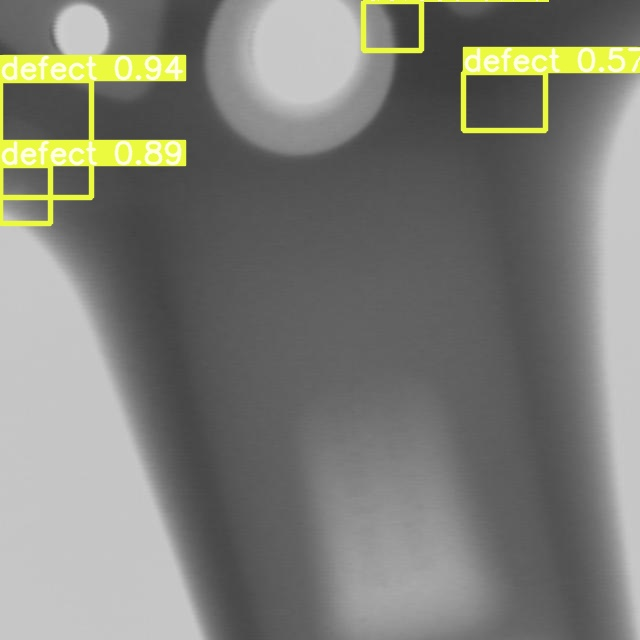

In [8]:
Image(filename='inference/output/C0001_0024_03.jpg', width=600)

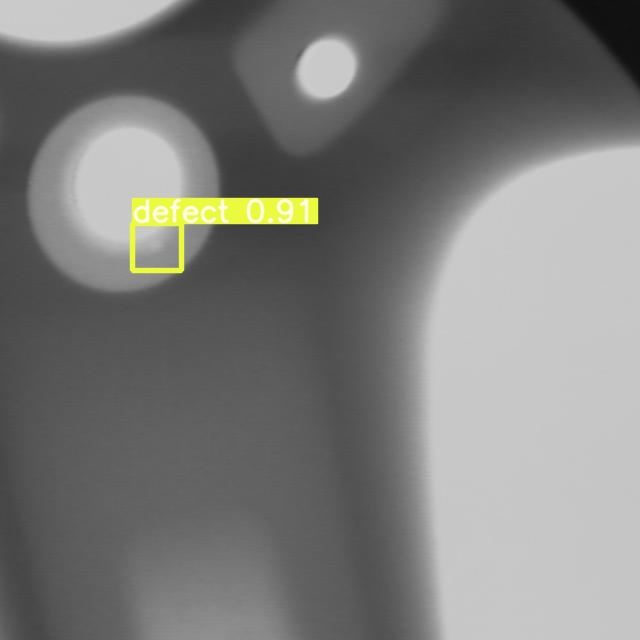

In [9]:
Image(filename='inference/output/C0001_0053_05.jpg', width=600)

In [10]:
# Backup of images with bounding boxes
!zip -r test_detection zip inference/output/
clear_output()
print('output images zipped in file test_detection.zip')


output images zipped in file test_detection.zip


In [ ]:
# DOWNLOAD RESULTS FROM test_detection.zip

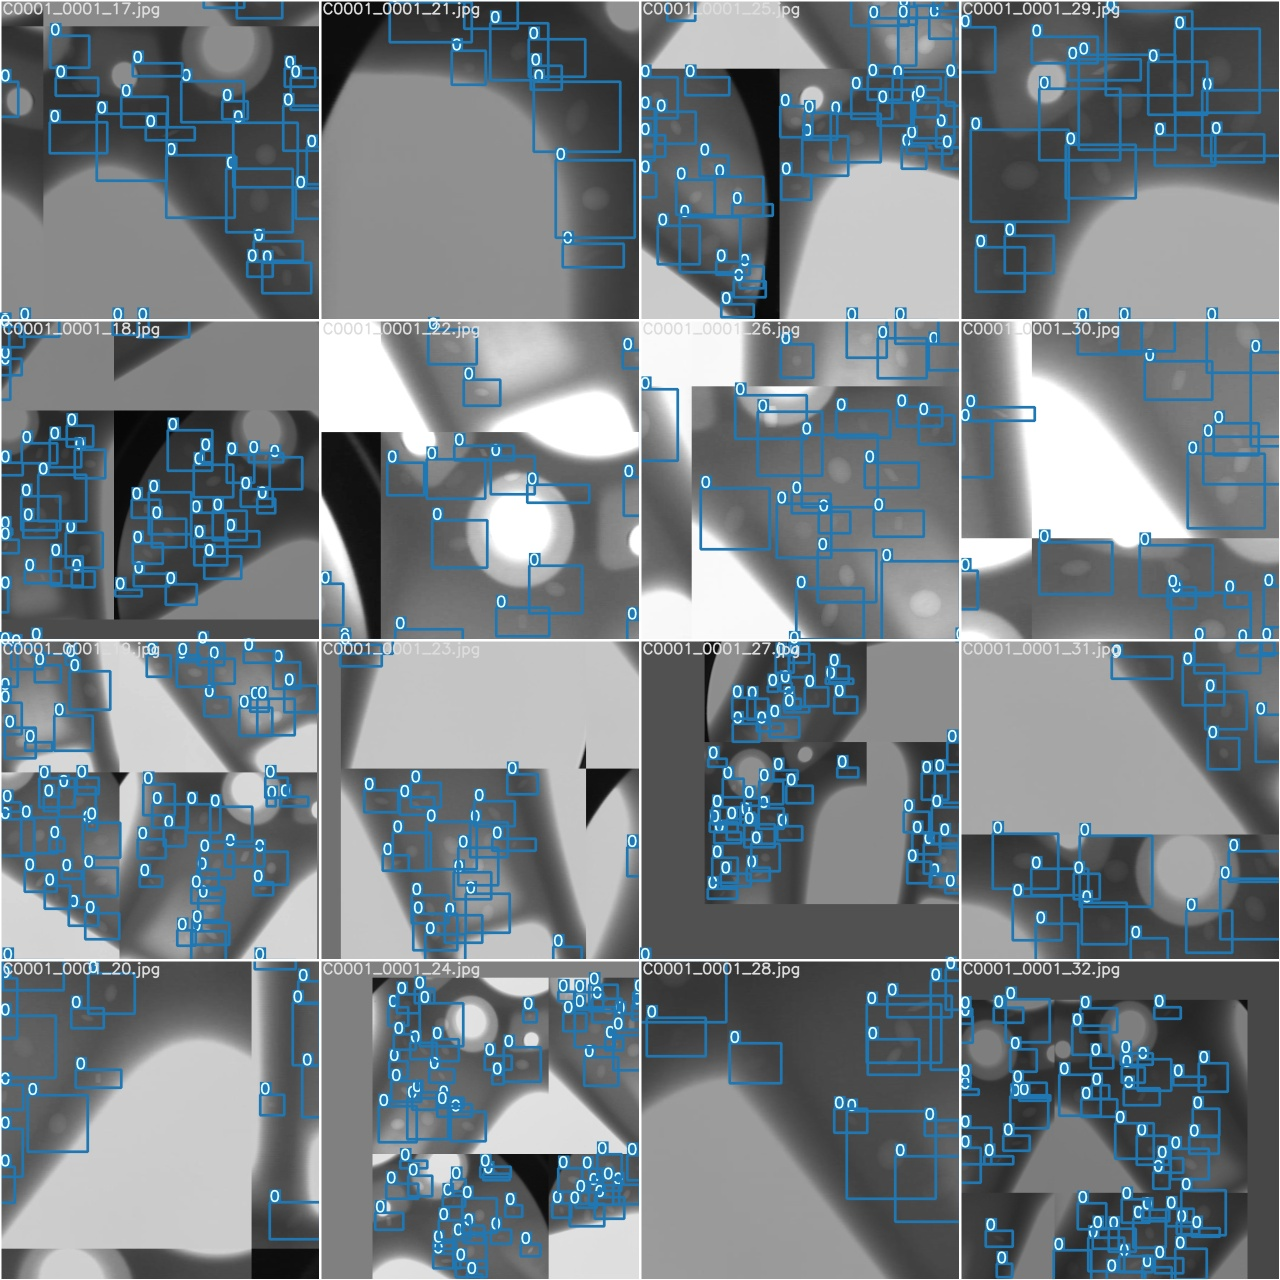

In [11]:
# view augmented training mosaics

Image(filename='runs/exp'+str(yexp)+'/train_batch1.jpg', width=900)  

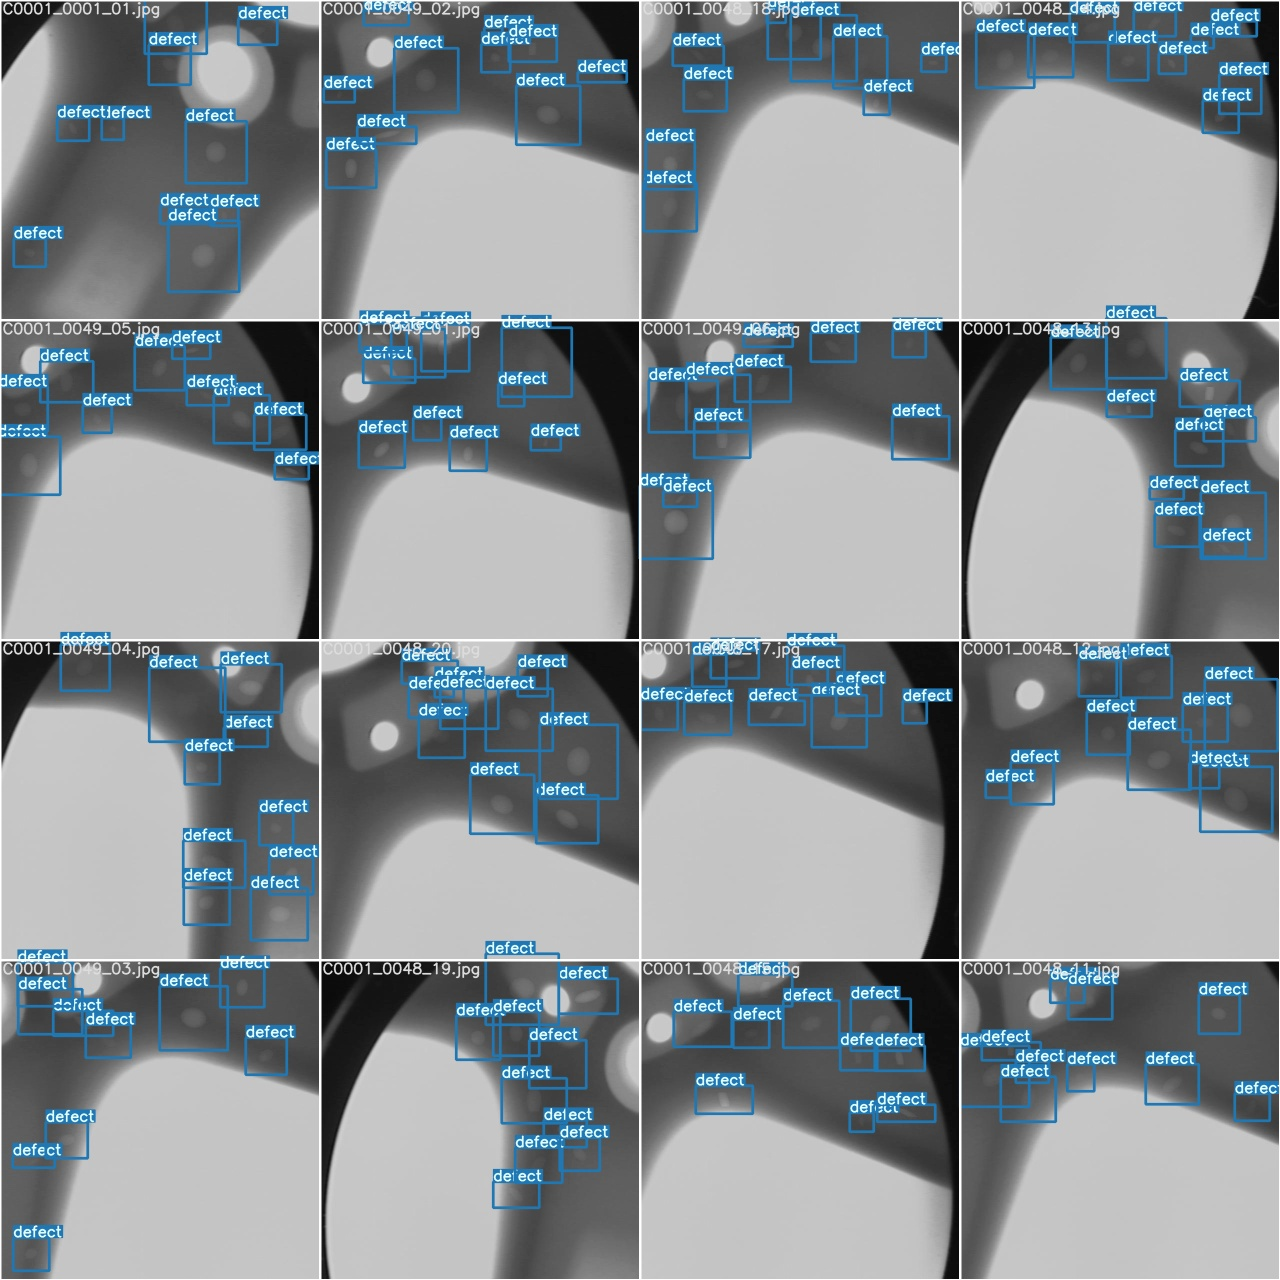

In [12]:
# view test image labels

Image(filename='runs/exp'+str(yexp)+'/test_batch0_gt.jpg', width=900) 

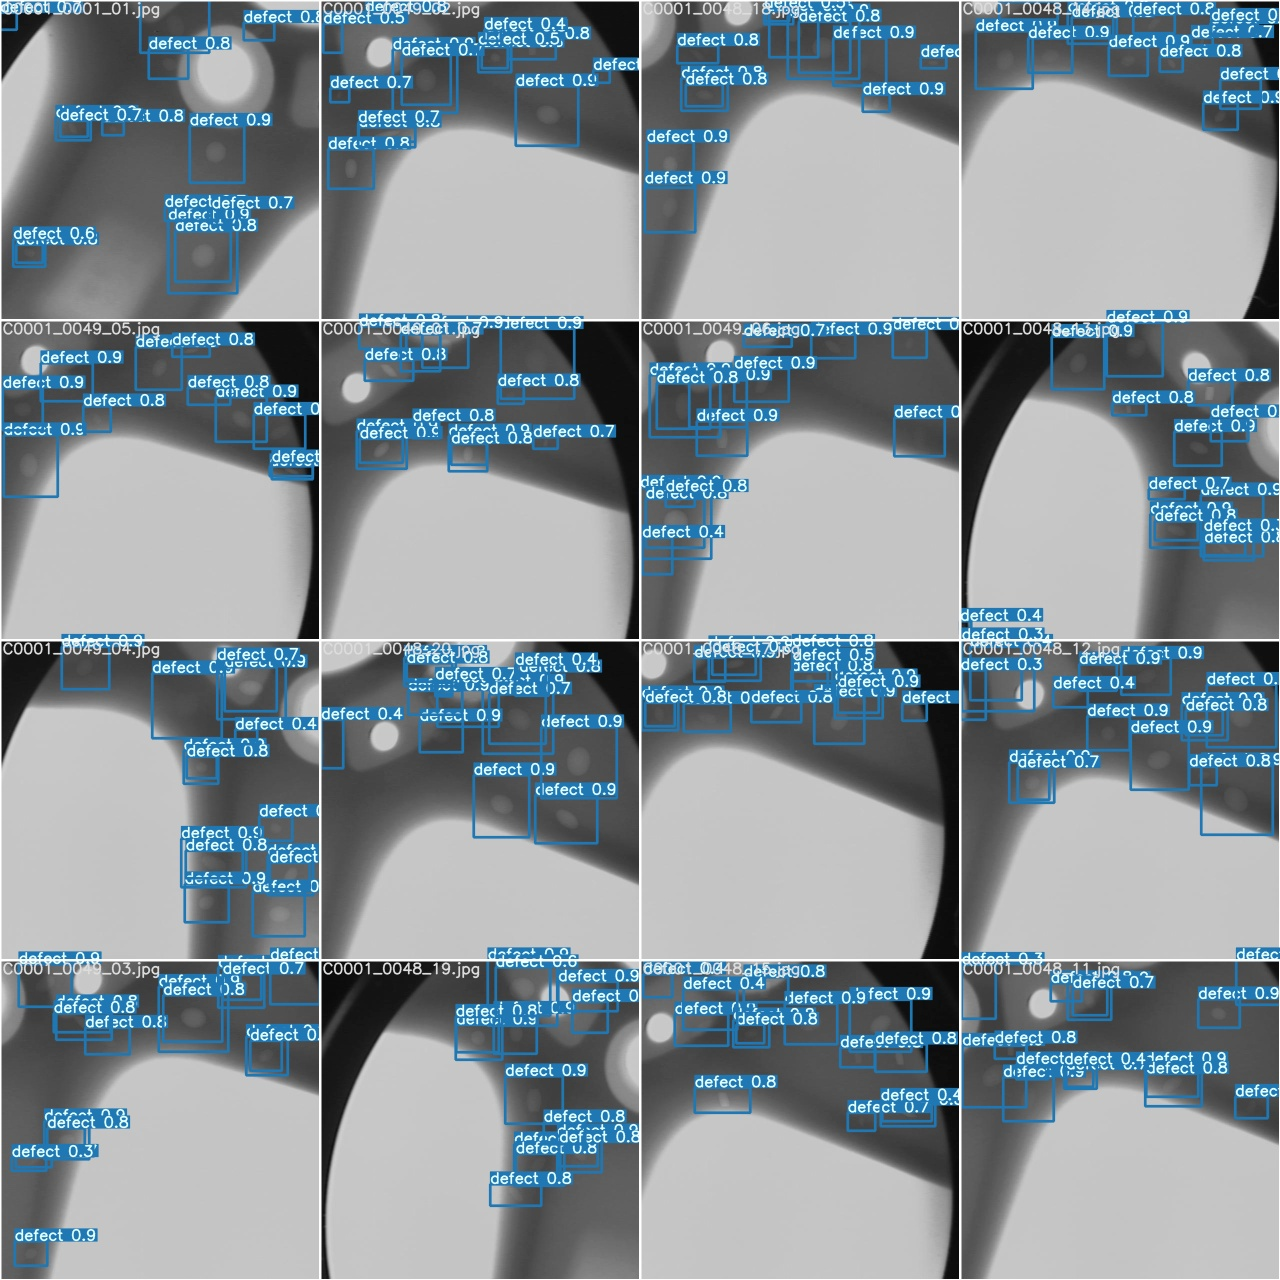

In [13]:
# view test image predictions

Image(filename='runs/exp'+str(yexp)+'/test_batch0_pred.jpg', width=900)  

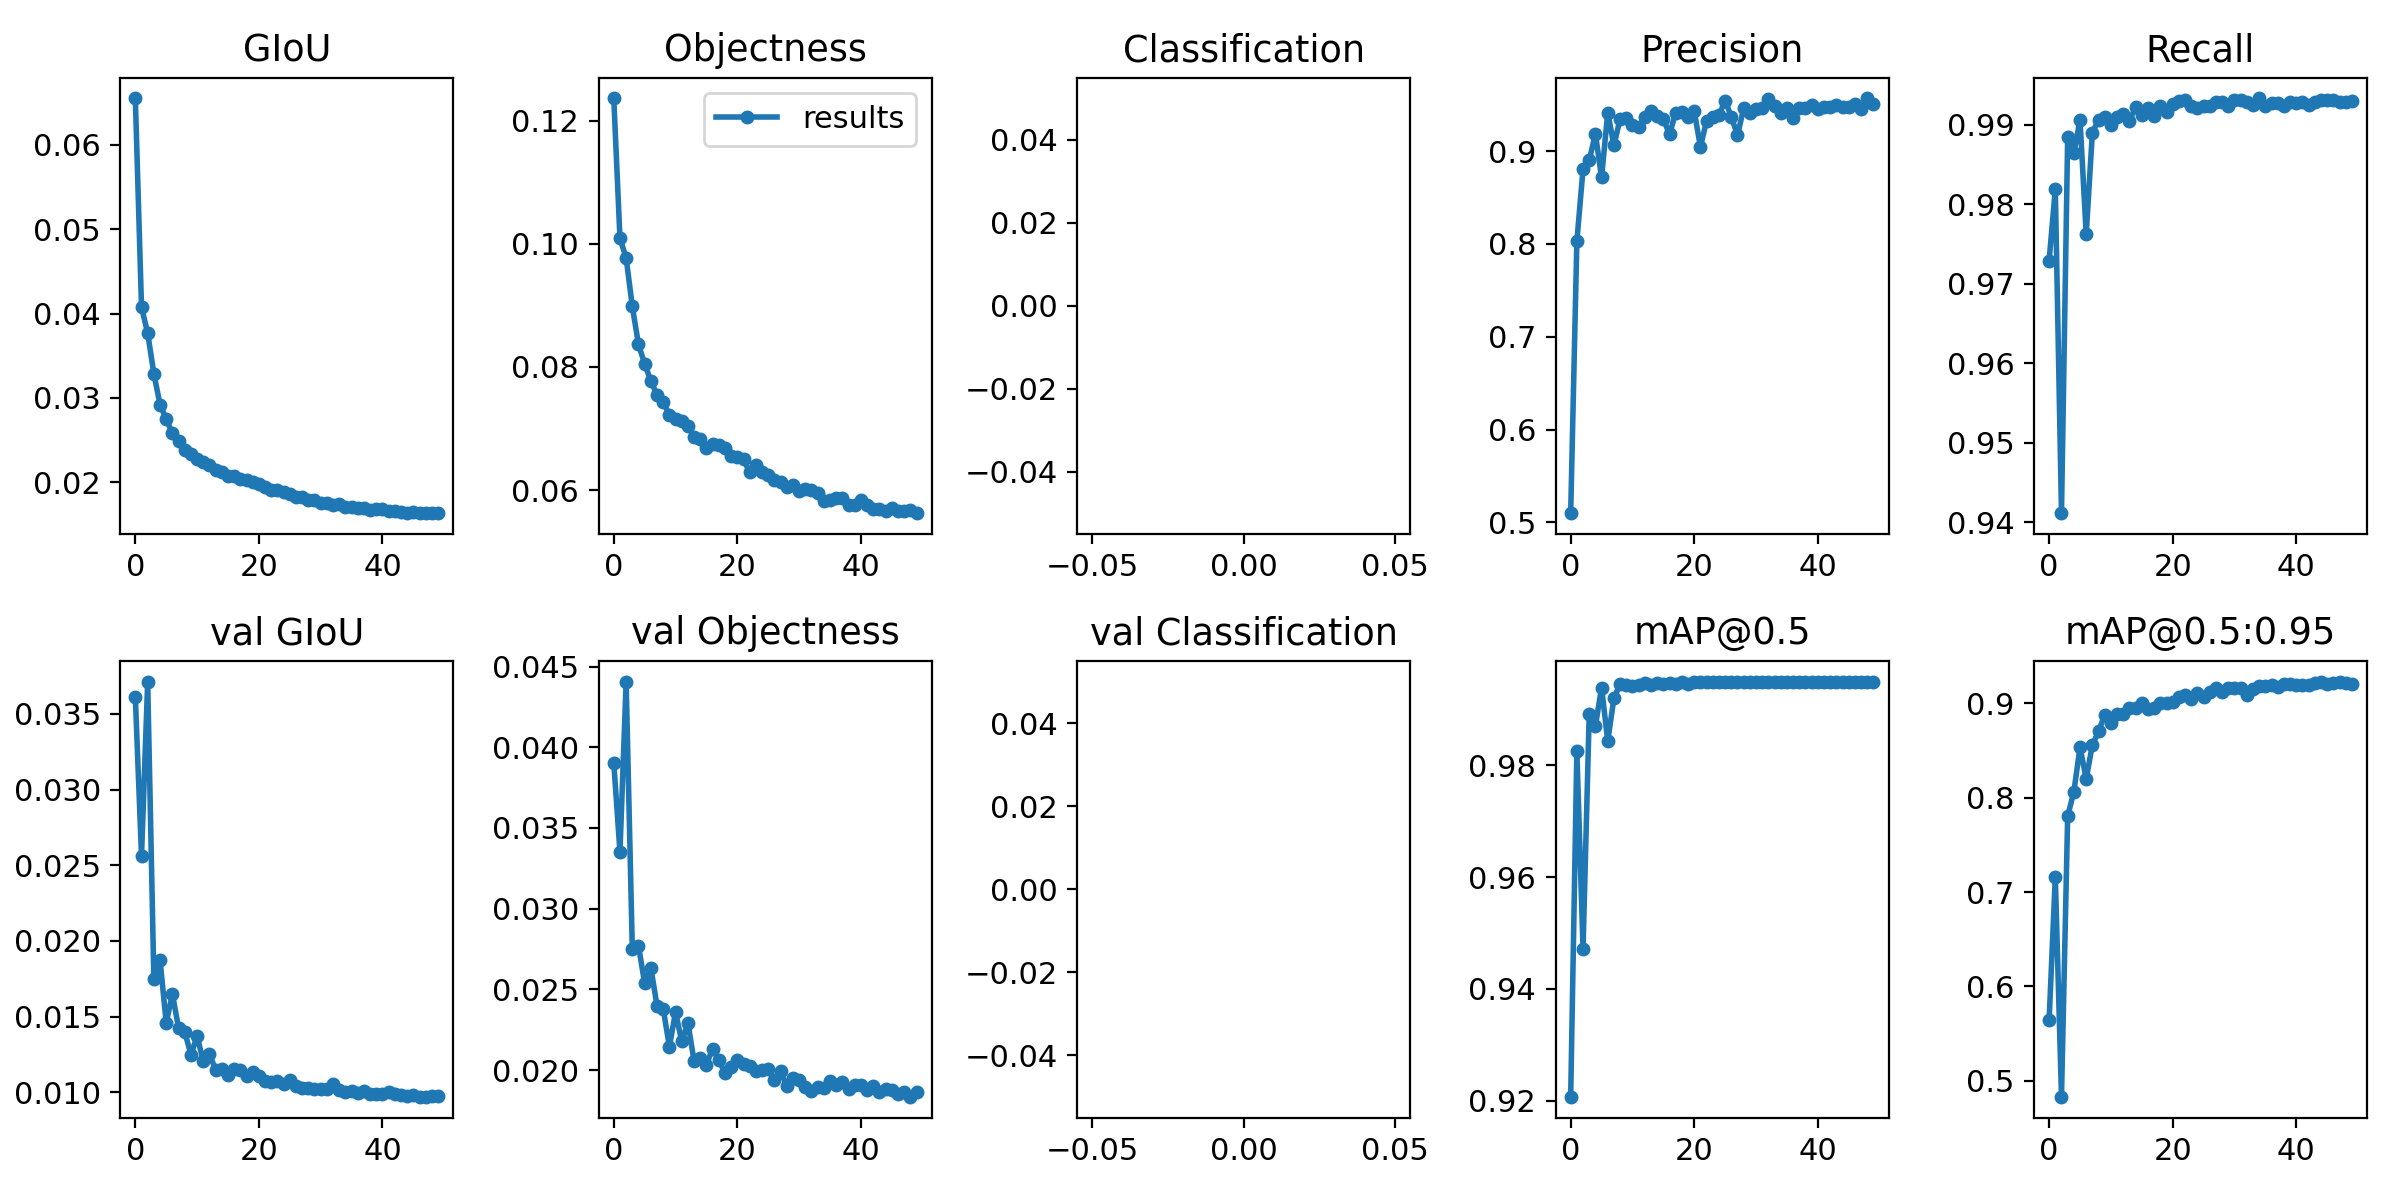

In [14]:
# view training curves

Image(filename='runs/exp'+str(yexp)+'/results.png', width=900)